<h1>Richter's Predictor: Modeling Earthquake Damage - Parte 2</h1>

Neste notebook eu analiso os dados da competição do DrivenData: https://www.drivendata.org/competitions/57/nepal-earthquake/page/134/.

A parte 1 desse projeto pode ser encontrada aqui: https://github.com/dericksaga/ML_Competitions/blob/main/Richters_Predictor/Ritchers_Predictor_v1.ipynb

Na parte 2 será utilizado um modelo de multilayer perceptron (redes neurais) aplicado aos dados gerados na parte 1.

As funções e o pipeline de tratamento dos dados a seguir são explicados de forma detalhada no arquivo indicado acima.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#irei importar as demais bibliotecas a medida que for necessário

data_path = 'D:\Documents\Google Drive\Competicoes\DrivenData\Earthquake'
train_data_file = os.path.join(data_path,'train_values.csv')
train_label_file = os.path.join(data_path,'train_labels.csv')
test_data_file = os.path.join(data_path,'test_values.csv')

#carregando os dados de treinamento e os rótulos da variável alvo
train_data = pd.read_csv(train_data_file, index_col='building_id')
label_data = pd.read_csv(train_label_file, index_col='building_id')

print("Datasets Loaded.")

#variáveis categóricas nominais
cat_attrs = [col for col in train_data.columns if train_data[col].dtype == 'object']
#variáveis categóricas binárias
bin_attrs = [col for col in train_data.columns if 'has_s' in col]
#variáveis quantitativas (ou numéricas)
num_attrs = [col for col in train_data.columns if (train_data[col].dtype == 'int64' and col not in bin_attrs)]


Datasets Loaded.


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder
#OneToOneFeatureMixin - Provides get_feature_names_out for simple transformers

class Remove_Outliers(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self):
        self.stdev = None
        None
        
    def fit(self, X, y=None):
        self.stdev = np.std(X[['age']])
        return self
    
    def transform(self, X, y=None):
        X1 = self.remove_outliers(df=X,n_dev=4,cols=['age'])
        return X1
    
    def remove_outliers(self,df, n_dev, cols):
        """Função para remover outliers substituindo por valores iguais
        a n_dev desvios-padrão nas colunas listadas em cols"""
        df1 = df.copy()
        for col in cols:
            threshold = 3*self.stdev[col]
            new_value = n_dev*self.stdev[col]
            df1[col]= df1[col].apply(lambda x: x if x<=threshold else new_value)
        return df1   
class Create_New_Attrs(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self):
        None
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X1 = X.copy()
        X1['h_per_a'] = X1['height_percentage']/X1['area_percentage']
        X1['families_per_area'] = X1['count_families']/X1['area_percentage']
        return X1
    
#adicionar uma classe que irá criar as novas variáveis geográficas
class Create_New_Geo_Codes(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self, labels):
        self.labels = labels
        self.geo_l1_codemap = None
        self.geo_l2_codemap = None
        return None
    
    def fit(self, X, y=None):
        X1 = X.copy()
        self.make_l1_codemap(X1)
        self.geo_l1_encoder(X1)
        self.geo_l2_codemap = self.make_l2_codemap(X1)
        return self
    
    def transform(self, X, y=None):
        X1 = X.copy()
        self.geo_l1_encoder(X1)
        self.geo_l2_encoder(X1)
        return X1
    
    def make_l1_codemap(self,data):
        #joining the geo_level_1_id with damage_grade to make the new code map
        train_label_data = data[['geo_level_1_id']].join(self.labels['damage_grade'])
        n_entries = train_label_data.shape[0]
        #at first I grouped the occurrences of damage_grade=3, count them and sort in ascending order
        self.geo_l1_codemap = train_label_data.groupby('geo_level_1_id').count()
        self.geo_l1_codemap['damage_3_count'] = train_label_data.loc[train_label_data['damage_grade']==3].groupby('geo_level_1_id').count()
        self.geo_l1_codemap['weighted_dg'] = self.geo_l1_codemap['damage_grade'] * self.geo_l1_codemap['damage_3_count']/n_entries
        self.geo_l1_codemap.sort_values(by=['weighted_dg'], inplace=True)
        self.geo_l1_codemap['new_code'] = range(0,31)
        return None
    
    def geo_l1_encoder(self,data):
        newlist = [self.geo_l1_codemap['new_code'].loc[data['geo_level_1_id'].iloc[i]] for i in range(data.shape[0])]
        data['geo_level_1_id_nc'] = newlist
        return data
    
    def make_l2_codemap(self,data):
        #cria um dataframe auxiliar ordenado pela nova codificação em geo_level_1
        aux2 = data[['geo_level_2_id','geo_level_1_id_nc']].sort_values('geo_level_1_id_nc',ascending=True).copy()
        #cria um dicionário com chave igual ao novo código de geo_level_1 e com valores igual a um segundo dicionário 
        #onde a chave é o geo_level_2_id e o valor é a quantidade de registros (edifícios) nessa área
        aux_s = {x:{y: aux2.loc[aux2['geo_level_2_id']==y].count()[0] for y in aux2.loc[aux2['geo_level_1_id_nc']==x,'geo_level_2_id'].unique()} for x in range(0,31)}
        j=0
        for i in aux_s.keys():
            #ordena as chaves do segundo dicionário a partir do valor de ocorrência, colocando os com maior quantidade no início
            size = len(aux_s[i])
            aux_s[i] = {'geo_level_2_id':pd.DataFrame(sorted(aux_s[i].items(), key= lambda item: item[1], reverse=True))[0].values,
                'new_code':range(j,j+size)}
            aux_s[i] = pd.DataFrame(aux_s[i]).set_index(['geo_level_2_id'])
            j+=size
        return aux_s
    
    def geo_l2_encoder(self,data):
        new_ids = []
        for building in data.index:
            id2 = data.loc[building,'geo_level_2_id']
            id1 = data.loc[building,'geo_level_1_id_nc']
            if id2 in self.geo_l2_codemap[id1].index:
                new_ids.append(self.geo_l2_codemap[id1].loc[id2,'new_code'])
            else:
                new_ids.append(self.geo_l2_codemap[id1].iloc[0]['new_code'])
        data['geo_level_2_id_nc'] = new_ids
        return data
#instancia a classe antes de inseri-la no pipeline    
create_new_geo_ids = Create_New_Geo_Codes(labels=label_data)
    
del_attrs = [col for col in bin_attrs if 'has_secondary_use_' in col]
for col in ['plan_configuration', 'count_families',
           'geo_level_1_id','geo_level_2_id','geo_level_3_id', 'legal_ownership_status']:
    del_attrs.append(col)

num_attrs_ = [col for col in num_attrs if col not in del_attrs]
coded_attrs = ['geo_level_1_id_nc','geo_level_2_id_nc']
cat_attrs_ = [col for col in cat_attrs if col not in del_attrs]

column_transformer = ColumnTransformer([
    ('num', StandardScaler(), num_attrs_),
    ('coded', MinMaxScaler(), coded_attrs),
    ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist',min_frequency=0.1,max_categories=3),cat_attrs_),
    ('drop', 'drop', del_attrs)],remainder='passthrough',verbose_feature_names_out=True)

        
pipe = Pipeline([('remove_outliers',Remove_Outliers()),
                ('create_new_attrs',Create_New_Attrs()),
                ('crete_new_geo_ids', create_new_geo_ids),
                ('column_tranformer', column_transformer)])
pipe

Pipeline(steps=[('remove_outliers', Remove_Outliers()),
                ('create_new_attrs', Create_New_Attrs()),
                ('crete_new_geo_ids',
                 Create_New_Geo_Codes(labels=             damage_grade
building_id              
802906                  3
28830                   2
94947                   3
590882                  2
201944                  3
...                   ...
688636                  2
669485                  3
602512                  3
151409                  2
747594                  3

[260601 rows x 1 columns])),
                ('column_tranformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', St...
                                                   'has_secondary_use_rental',
                                                   'has_secondary_use_institution',
                                                   'has_secondary_use_school',
                                                   'has_secondary_use_industry',
                                                   'has_secondary_use_health_post',
                                                   'has_secondary_use_gov_office',
                                                   'has_secondary_use_use_police',
                                                   'has_secondary_use_other',
                                                   'plan_configuration',
                                                   'count_families',
                                                   'geo_level_1_id',
                                                   'geo_level_2_id',
                                                   'geo_level_3_id',
                                                   'legal_ownership_status'])]))])

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
#split the training dataset stratifying by damage_grade
for train_index, test_index in splitter.split(train_data,label_data):
    strat_train_set = train_data.iloc[train_index]
    strat_val_set = train_data.iloc[test_index]
    label_train_set = label_data.iloc[train_index]
    label_val_set = label_data.iloc[test_index]

train_data_prepared = pipe.fit_transform(strat_train_set)
val_data_prepared = pipe.transform(strat_val_set)


Como a etapa de criação de novos atributos no pipeline de processamento demora vários segundos para ser executada, o pipeline de processamento dos dados ficará à parte do treinamento do modelo, para otimizar o tempo de execução do código.

<h3>Treinamento do Modelo</h3>

É necessário realizar um pequeno pré-processamento no conjunto da variável alvo, uma vez que as classes são: {1, 2, 3}, é preciso codificá-las para {0, 1, 2} para serem processadas por Modelo Sequencial que será construído com 3 saídas. 
Posteriormente ao fazer as previsões com o conjunto de dados de teste para submissão, será necessário somar 1 ao resultado entregue pelo modelo.

Inicialmente o MLP consistirá em 3 camadas ocultas com função de ativação ReLU, com 100 neurônios cada. E uma camada de saída com 3 neurônios, cada um representando uma classe, e função de ativação SoftMax, por se tratar de um problema de classificação multiclasse.


In [4]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from sklearn.metrics import f1_score

#passa as classes de 1,2,3 para 0,1,2
label_train_set -= 1
label_val_set -= 1

model = keras.models.Sequential([keras.layers.InputLayer(input_shape=(train_data_prepared.shape[1],)),
                                  keras.layers.Dense(100, activation='relu'),
                                  keras.layers.Dense(100, activation='relu'),
                                  keras.layers.Dense(50, activation='relu'),
                                  keras.layers.Dense(3, activation='softmax')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               3700      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 3)                 153       
                                                                 
Total params: 19,003
Trainable params: 19,003
Non-trainable params: 0
_________________________________________________________________


Para usar o F1 Score como métrica de treinamento é preciso utilizar a biblioteca tensorflow_addons e a variável alvo deve estar codificada como uma matriz no formato One-Hot. Dessa forma, utiliza-se a função de perda: categorical_crossentropy.

In [5]:
#codifica a variável alvo para one-hot para usar o F1Score
label_train_prepared = keras.utils.to_categorical(label_train_set, num_classes=3)
label_val_prepared = keras.utils.to_categorical(label_val_set, num_classes=3)

#especifica função de perda, otimizador e métricas
model.compile(loss='categorical_crossentropy',
             optimizer=keras.optimizers.SGD(learning_rate=0.05), metrics=[tfa.metrics.F1Score(num_classes=3, average='micro')])

#define um callback de EarlyStopping caso não haja progresso na validação após 5 épocas
history = model.fit(train_data_prepared, label_train_prepared, epochs=50,verbose=1,
                   validation_data=[val_data_prepared, label_val_prepared], 
                    callbacks=[keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)])

Epoch 1/50
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
7330/7330 [==============================] - 12s 2ms/step - loss: 0.7562 - f1_score: 0.6238 - val_loss: 0.7372 - val_f1_score: 0.6337
Epoch 2/50
7330/7330 [==============================] - 11s 2ms/step - loss: 0.7373 - f1_score: 0.6362 - val_loss: 0.7315 - val_f1_score: 0.6410
Epoch 3/50
7330/7330 [==============================] - 14s 2ms/step - loss: 0.7315 - f1_score: 0.6406 - val_loss: 0.7309 - val_f1_score: 0.6396
Epoch 4/50
7330/7330 [==============================] - 11s 2ms/step - loss: 0.7266 - f1_score: 0.6446 - val_loss: 0.7322 - val_f1_score: 0.6361
Epoch 5/50
7330/7330 [==============================] - 13s 2ms/step - loss: 0.7217 - f1_score: 0.6488 - val_loss: 0.7222 - val_f1_score: 0.6467
Epoch 6/50
7330/7330 [==============================] - 12s 2ms/step - los

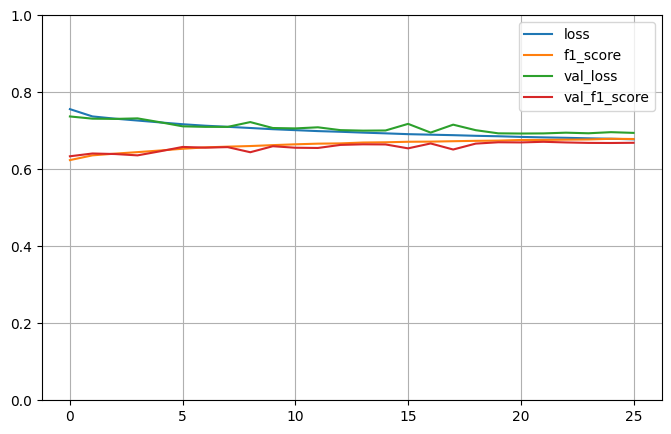

In [6]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [12]:
val_sample_preds = np.round(model.predict(val_data_prepared))
print('F1_Score com conjunto de validação: ',f1_score(label_val_prepared, val_sample_preds, average='micro'))

815/815 [==============================] - 1s 1ms/step
F1_Score com conjunto de validação:  0.6653428337811004


O modelo não performou melhor do que o RandomForest utilizado na parte 1. 

Pode-se tentar otimizar alguns hiperparâmetros associados à construção do modelo e às etapas de treinamento. Para isso é necessário utilizar um wrapper de um classifier para que ele possa ser instanciado no gridsearch (ou no randomizedsearch).

In [13]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier, KerasRegressor

input_shape = train_data_prepared.shape[1]
#Define a função que será utilizada no KerasClassifier, essa função tem como entrada
#os hiperparametros que serão otimizados
def my_model(n_hidden=1, n_neurons=100, learning_rate=0.032, input_shape=input_shape):
    """n_hidden: número de camadas ocultas,
    n_neurons: número de neurônios das camadas ocultas,
    learning_rate: taxa de aprendizado
    input_shape = número de neurônios da camada de entrada"""
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    #add camadas ocultas pela quantidade de n_hidden
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
    model.add(keras.layers.Dense(3, activation='softmax'))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
                  metrics=[tfa.metrics.F1Score(num_classes=3, average='micro')])
    return model

#cria um classifier utilizando a função my_model que cria o modelo
keras_clas = KerasClassifier(model=my_model, learning_rate=3e-2, n_hidden=3,
                            n_neurons=100, metrics='f1_micro')

#intervalos depossíveis valores para cada hiperparâmetro
param_distrib = {'n_hidden':[3,4,5],
                 'n_neurons':np.arange(100,150,200),
                 'learning_rate':reciprocal(1e-2, 1e-1),
                 'batch_size':[64, 128, 256]}

model_rnd_search = RandomizedSearchCV(keras_clas, param_distrib, n_iter=4, cv=3, 
                                      scoring='f1_micro',refit='f1_micro', verbose=3)

model_rnd_search.fit(train_data_prepared, label_train_prepared, epochs=50,
                    validation_data=[val_data_prepared, label_val_prepared],
                    callbacks=[keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)])


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Epoch 1/50
1222/1222 [==============================] - 3s 2ms/step - loss: 0.8082 - f1_score: 0.5931 - val_loss: 0.7670 - val_f1_score: 0.6231
Epoch 2/50
1222/1222 [==============================] - 3s 2ms/step - loss: 0.7615 - f1_score: 0.6259 - val_loss: 0.7551 - val_f1_score: 0.6289
Epoch 3/50
1222/1222 [==============================] - 3s 2ms/step - loss: 0.7538 - f1_score: 0.6298 - val_loss: 0.7501 - val_f1_score: 0.6319
Epoch 4/50
1222/1222 [==============================] - 3s 2ms/step - loss: 0.7493 - f1_score: 0.6337 - val_loss: 0.7467 - val_f1_score: 0.6341
Epoch 5/50
1222/1222 [==============================] - 3s 2ms/step - loss: 0.7462 - f1_score: 0.6347 - val_loss: 0.7440 - val_f1_score: 0.6359
Epoch 6/50
1222/1222 [==============================] - 3s 2ms/step - loss: 0.7435 - f1_score: 0.6358 - val_loss: 0.7421 - val_f1_score: 0.6332
Epoch 7/50
1222/1222 [==============================] - 3s 2ms/step - loss: 

Epoch 6/50
1222/1222 [==============================] - 3s 2ms/step - loss: 0.7444 - f1_score: 0.6339 - val_loss: 0.7444 - val_f1_score: 0.6353
Epoch 7/50
1222/1222 [==============================] - 3s 2ms/step - loss: 0.7417 - f1_score: 0.6353 - val_loss: 0.7439 - val_f1_score: 0.6314
Epoch 8/50
1222/1222 [==============================] - 3s 2ms/step - loss: 0.7396 - f1_score: 0.6364 - val_loss: 0.7396 - val_f1_score: 0.6352
Epoch 9/50
1222/1222 [==============================] - 3s 2ms/step - loss: 0.7377 - f1_score: 0.6375 - val_loss: 0.7437 - val_f1_score: 0.6311
Epoch 10/50
1222/1222 [==============================] - 3s 2ms/step - loss: 0.7362 - f1_score: 0.6387 - val_loss: 0.7364 - val_f1_score: 0.6354
Epoch 11/50
1222/1222 [==============================] - 3s 2ms/step - loss: 0.7350 - f1_score: 0.6381 - val_loss: 0.7369 - val_f1_score: 0.6367
Epoch 12/50
1222/1222 [==============================] - 3s 2ms/step - loss: 0.7339 - f1_score: 0.6396 - val_loss: 0.7348 - val_f1_sco

1222/1222 [==============================] - 3s 2ms/step - loss: 0.7365 - f1_score: 0.6391 - val_loss: 0.7346 - val_f1_score: 0.6405
Epoch 12/50
1222/1222 [==============================] - 3s 3ms/step - loss: 0.7353 - f1_score: 0.6413 - val_loss: 0.7338 - val_f1_score: 0.6402
Epoch 13/50
1222/1222 [==============================] - 3s 3ms/step - loss: 0.7345 - f1_score: 0.6402 - val_loss: 0.7333 - val_f1_score: 0.6414
Epoch 14/50
1222/1222 [==============================] - 3s 3ms/step - loss: 0.7335 - f1_score: 0.6410 - val_loss: 0.7326 - val_f1_score: 0.6389
Epoch 15/50
1222/1222 [==============================] - 3s 2ms/step - loss: 0.7327 - f1_score: 0.6408 - val_loss: 0.7318 - val_f1_score: 0.6389
Epoch 16/50
1222/1222 [==============================] - 3s 2ms/step - loss: 0.7317 - f1_score: 0.6413 - val_loss: 0.7334 - val_f1_score: 0.6390
Epoch 17/50
1222/1222 [==============================] - 3s 2ms/step - loss: 0.7310 - f1_score: 0.6423 - val_loss: 0.7299 - val_f1_score: 0.64

2444/2444 [==============================] - 5s 2ms/step - loss: 0.6987 - f1_score: 0.6667 - val_loss: 0.7143 - val_f1_score: 0.6512
Epoch 17/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6968 - f1_score: 0.6676 - val_loss: 0.7146 - val_f1_score: 0.6526
Epoch 18/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6943 - f1_score: 0.6678 - val_loss: 0.7214 - val_f1_score: 0.6571
Epoch 19/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6928 - f1_score: 0.6690 - val_loss: 0.7023 - val_f1_score: 0.6616
Epoch 20/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6910 - f1_score: 0.6704 - val_loss: 0.7490 - val_f1_score: 0.6151
Epoch 21/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6893 - f1_score: 0.6713 - val_loss: 0.7426 - val_f1_score: 0.6202
Epoch 22/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6879 - f1_score: 0.6727 - val_loss: 0.7043 - val_f1_score: 0.65

2444/2444 [==============================] - 7s 3ms/step - loss: 0.6886 - f1_score: 0.6725 - val_loss: 0.7207 - val_f1_score: 0.6585
Epoch 22/50
2444/2444 [==============================] - 7s 3ms/step - loss: 0.6864 - f1_score: 0.6741 - val_loss: 0.7518 - val_f1_score: 0.6146
Epoch 23/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6848 - f1_score: 0.6743 - val_loss: 0.7382 - val_f1_score: 0.6319
Epoch 24/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6832 - f1_score: 0.6762 - val_loss: 0.7042 - val_f1_score: 0.6656
Epoch 25/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6819 - f1_score: 0.6759 - val_loss: 0.7129 - val_f1_score: 0.6602
Epoch 26/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6806 - f1_score: 0.6773 - val_loss: 0.7433 - val_f1_score: 0.6239
Epoch 27/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6793 - f1_score: 0.6783 - val_loss: 0.7119 - val_f1_score: 0.66

2444/2444 [==============================] - 6s 2ms/step - loss: 0.6831 - f1_score: 0.6773 - val_loss: 0.7111 - val_f1_score: 0.6624
Epoch 27/50
2444/2444 [==============================] - 6s 3ms/step - loss: 0.6816 - f1_score: 0.6776 - val_loss: 0.8233 - val_f1_score: 0.5829
Epoch 28/50
2444/2444 [==============================] - 6s 2ms/step - loss: 0.6804 - f1_score: 0.6778 - val_loss: 0.7205 - val_f1_score: 0.6506
Epoch 29/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6791 - f1_score: 0.6787 - val_loss: 0.7081 - val_f1_score: 0.6618
Epoch 30/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6782 - f1_score: 0.6795 - val_loss: 0.7062 - val_f1_score: 0.6610
Epoch 31/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6767 - f1_score: 0.6803 - val_loss: 0.7071 - val_f1_score: 0.6625
Epoch 32/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6747 - f1_score: 0.6820 - val_loss: 0.7173 - val_f1_score: 0.66

2444/2444 [==============================] - 5s 2ms/step - loss: 0.6753 - f1_score: 0.6817 - val_loss: 0.7080 - val_f1_score: 0.6650
Epoch 32/50
2444/2444 [==============================] - 6s 2ms/step - loss: 0.6732 - f1_score: 0.6817 - val_loss: 0.7173 - val_f1_score: 0.6527
Epoch 33/50
2444/2444 [==============================] - 6s 3ms/step - loss: 0.6727 - f1_score: 0.6830 - val_loss: 0.7246 - val_f1_score: 0.6461
Epoch 34/50
2444/2444 [==============================] - 6s 2ms/step - loss: 0.6710 - f1_score: 0.6841 - val_loss: 0.7066 - val_f1_score: 0.6581
Epoch 35/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6700 - f1_score: 0.6846 - val_loss: 0.7042 - val_f1_score: 0.6591
Epoch 36/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6686 - f1_score: 0.6847 - val_loss: 0.7272 - val_f1_score: 0.6553
Epoch 37/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6676 - f1_score: 0.6860 - val_loss: 0.7000 - val_f1_score: 0.67

2444/2444 [==============================] - 5s 2ms/step - loss: 0.6660 - f1_score: 0.6852 - val_loss: 0.7078 - val_f1_score: 0.6656
Epoch 37/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6648 - f1_score: 0.6860 - val_loss: 0.7142 - val_f1_score: 0.6652
Epoch 38/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6636 - f1_score: 0.6867 - val_loss: 0.7320 - val_f1_score: 0.6481
Epoch 39/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6623 - f1_score: 0.6879 - val_loss: 0.7149 - val_f1_score: 0.6589
Epoch 40/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6611 - f1_score: 0.6882 - val_loss: 0.7093 - val_f1_score: 0.6657
Epoch 41/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6605 - f1_score: 0.6886 - val_loss: 0.7188 - val_f1_score: 0.6672
Epoch 42/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6588 - f1_score: 0.6892 - val_loss: 0.7022 - val_f1_score: 0.67

2444/2444 [==============================] - 5s 2ms/step - loss: 0.6626 - f1_score: 0.6897 - val_loss: 0.7120 - val_f1_score: 0.6648
Epoch 42/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6610 - f1_score: 0.6900 - val_loss: 0.7063 - val_f1_score: 0.6639
Epoch 43/50
2444/2444 [==============================] - 6s 2ms/step - loss: 0.6601 - f1_score: 0.6911 - val_loss: 0.7015 - val_f1_score: 0.6697
Epoch 44/50
2444/2444 [==============================] - 6s 2ms/step - loss: 0.6587 - f1_score: 0.6916 - val_loss: 0.7242 - val_f1_score: 0.6607
Epoch 45/50
2444/2444 [==============================] - 6s 2ms/step - loss: 0.6576 - f1_score: 0.6916 - val_loss: 0.8435 - val_f1_score: 0.6146
Epoch 46/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6562 - f1_score: 0.6937 - val_loss: 0.7455 - val_f1_score: 0.6426
Epoch 47/50
2444/2444 [==============================] - 5s 2ms/step - loss: 0.6550 - f1_score: 0.6937 - val_loss: 0.7131 - val_f1_score: 0.65

611/611 [==============================] - 2s 3ms/step - loss: 0.7160 - f1_score: 0.6515 - val_loss: 0.7227 - val_f1_score: 0.6478
Epoch 48/50
611/611 [==============================] - 2s 3ms/step - loss: 0.7158 - f1_score: 0.6515 - val_loss: 0.7194 - val_f1_score: 0.6472
Epoch 49/50
611/611 [==============================] - 2s 4ms/step - loss: 0.7152 - f1_score: 0.6516 - val_loss: 0.7275 - val_f1_score: 0.6411
Epoch 50/50
306/306 [==============================] - 1s 2ms/step
[CV 1/3] END batch_size=256, learning_rate=0.024312635408100004, n_hidden=3, n_neurons=100;, score=0.646 total time= 1.8min
Epoch 1/50
611/611 [==============================] - 3s 4ms/step - loss: 0.8226 - f1_score: 0.5829 - val_loss: 0.7821 - val_f1_score: 0.6037
Epoch 2/50
611/611 [==============================] - 2s 3ms/step - loss: 0.7707 - f1_score: 0.6173 - val_loss: 0.7624 - val_f1_score: 0.6252
Epoch 3/50
611/611 [==============================] - 2s 3ms/step - loss: 0.7596 - f1_score: 0.6249 - val_lo

Epoch 2/50
611/611 [==============================] - 2s 3ms/step - loss: 0.7810 - f1_score: 0.6066 - val_loss: 0.7654 - val_f1_score: 0.6241
Epoch 3/50
611/611 [==============================] - 2s 3ms/step - loss: 0.7631 - f1_score: 0.6214 - val_loss: 0.7558 - val_f1_score: 0.6267
Epoch 4/50
611/611 [==============================] - 2s 3ms/step - loss: 0.7571 - f1_score: 0.6264 - val_loss: 0.7517 - val_f1_score: 0.6301
Epoch 5/50
611/611 [==============================] - 2s 3ms/step - loss: 0.7537 - f1_score: 0.6284 - val_loss: 0.7492 - val_f1_score: 0.6297
Epoch 6/50
611/611 [==============================] - 2s 3ms/step - loss: 0.7511 - f1_score: 0.6295 - val_loss: 0.7461 - val_f1_score: 0.6325
Epoch 7/50
611/611 [==============================] - 2s 3ms/step - loss: 0.7484 - f1_score: 0.6306 - val_loss: 0.7441 - val_f1_score: 0.6332
Epoch 8/50
611/611 [==============================] - 2s 3ms/step - loss: 0.7461 - f1_score: 0.6327 - val_loss: 0.7423 - val_f1_score: 0.6342
Epoch 

3665/3665 [==============================] - 10s 3ms/step - loss: 0.7116 - f1_score: 0.6567 - val_loss: 0.7097 - val_f1_score: 0.6562
Epoch 9/50
3665/3665 [==============================] - 8s 2ms/step - loss: 0.7083 - f1_score: 0.6606 - val_loss: 0.7083 - val_f1_score: 0.6631
Epoch 10/50
3665/3665 [==============================] - 8s 2ms/step - loss: 0.7053 - f1_score: 0.6621 - val_loss: 0.7029 - val_f1_score: 0.6628
Epoch 11/50
3665/3665 [==============================] - 8s 2ms/step - loss: 0.7024 - f1_score: 0.6642 - val_loss: 0.7047 - val_f1_score: 0.6595
Epoch 12/50
3665/3665 [==============================] - 7s 2ms/step - loss: 0.6996 - f1_score: 0.6666 - val_loss: 0.7132 - val_f1_score: 0.6572
Epoch 13/50
3665/3665 [==============================] - 8s 2ms/step - loss: 0.6975 - f1_score: 0.6686 - val_loss: 0.7050 - val_f1_score: 0.6606
Epoch 14/50
3665/3665 [==============================] - 8s 2ms/step - loss: 0.6951 - f1_score: 0.6684 - val_loss: 0.6963 - val_f1_score: 0.66

RandomizedSearchCV(cv=3,
                   estimator=KerasClassifier(learning_rate=0.03, metrics='f1_micro', model=<function my_model at 0x000002B6A73151F0>, n_hidden=3, n_neurons=100),
                   n_iter=4,
                   param_distributions={'batch_size': [64, 128, 256],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002B6ABA1B700>,
                                        'n_hidden': [3, 4, 5],
                                        'n_neurons': array([100])},
                   refit='f1_micro', scoring='f1_micro', verbose=3)

In [14]:
val_sample_preds = model_rnd_search.predict(val_data_prepared)
print('F1_Score com conjunto de validação: ',f1_score(label_val_prepared, val_sample_preds, average='micro'))

408/408 [==============================] - 1s 1ms/step
F1_Score com conjunto de validação:  0.675607229193047


In [19]:
model_rnd_search.best_params_

{'batch_size': 64,
 'learning_rate': 0.06465412660005707,
 'n_hidden': 4,
 'n_neurons': 100}

O modelo encontrado performou um pouco melhor com relação ao conjunto de dados de validação, se comparado ao primeiro. No entanto, os modelos ainda estavam convergindo ao final das 50 épocas. 

Para não demandar muito mais tempo de processamento, ao invés de aumentar a quantidade de épocas, serão feitas alterações no pipeline de processamento de forma a tornar o conjunto de dados menos espasso (com menos atributos binários). Reduzindo a quantidade de atributos e entradas da rede neural.

Para isso, serão excluídas todas as variáveis de flag de superestrutura. E a codificação das variáveis categóricas será alterada de One-Hot para codificação ordinal.

In [20]:
from sklearn.preprocessing import OrdinalEncoder

#Cria novo pipeline com outro codificador para as variáveis categóricas
del_attrs = bin_attrs
for col in ['plan_configuration', 'count_families',
           'geo_level_1_id','geo_level_2_id','geo_level_3_id', 'legal_ownership_status']:
    del_attrs.append(col)

num_attrs_ = [col for col in num_attrs if col not in del_attrs]
coded_attrs = ['geo_level_1_id_nc','geo_level_2_id_nc']
cat_attrs_ = [col for col in cat_attrs if col not in del_attrs]

#Além de codificar para um valor ordinal, é necessário ajustar a escala em seguida
#para que esses atributos não enviesem o modelo durante o treinamento
ordinal_pipe = Pipeline([('ordinal_encoder',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)),
                        ('ordinal_scaler', MinMaxScaler())])

column_transformer = ColumnTransformer([
    ('num', StandardScaler(), num_attrs_),
    ('coded', MinMaxScaler(), coded_attrs),
    ('ord_enc', ordinal_pipe ,cat_attrs_),
    ('drop', 'drop', del_attrs)],remainder='passthrough',verbose_feature_names_out=True)

        
pipe2 = Pipeline([('remove_outliers',Remove_Outliers()),
                ('create_new_attrs',Create_New_Attrs()),
                ('crete_new_geo_ids', create_new_geo_ids),
                ('column_tranformer', column_transformer)])
pipe2

Pipeline(steps=[('remove_outliers', Remove_Outliers()),
                ('create_new_attrs', Create_New_Attrs()),
                ('crete_new_geo_ids',
                 Create_New_Geo_Codes(labels=             damage_grade
building_id              
802906                  3
28830                   2
94947                   3
590882                  2
201944                  3
...                   ...
688636                  2
669485                  3
602512                  3
151409                  2
747594                  3

[260601 rows x 1 columns])),
                ('column_tranformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', St...
                                                   'has_secondary_use_rental',
                                                   'has_secondary_use_institution',
                                                   'has_secondary_use_school',
                                                   'has_secondary_use_industry',
                                                   'has_secondary_use_health_post',
                                                   'has_secondary_use_gov_office',
                                                   'has_secondary_use_use_police',
                                                   'has_secondary_use_other',
                                                   'plan_configuration',
                                                   'count_families',
                                                   'geo_level_1_id',
                                                   'geo_level_2_id',
                                                   'geo_level_3_id',
                                                   'legal_ownership_status'])]))])

In [21]:
train_data_prepared = pipe2.fit_transform(strat_train_set)
val_data_prepared = pipe2.transform(strat_val_set)

Será criado um modelo com os mesmos parâmetros daquele testado inicialmente nesse notebook, de maneira que se possa comparar a efetividade dessa alteração no pipeline de processamento para o processo de treinamento.

In [23]:
model2 = keras.models.Sequential([keras.layers.InputLayer(input_shape=(train_data_prepared.shape[1],)),
                                  keras.layers.Dense(100, activation='relu'),
                                  keras.layers.Dense(100, activation='relu'),
                                  keras.layers.Dense(50, activation='relu'),
                                  keras.layers.Dense(3, activation='softmax')])
model2.summary()
model2.compile(loss='categorical_crossentropy',
             optimizer=keras.optimizers.SGD(learning_rate=0.05), metrics=[tfa.metrics.F1Score(num_classes=3, average='micro')])
history = model2.fit(train_data_prepared, label_train_prepared, epochs=50,
                   validation_data=[val_data_prepared, label_val_prepared], 
                     callbacks=[keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)])

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_67 (Dense)            (None, 100)               1500      
                                                                 
 dense_68 (Dense)            (None, 100)               10100     
                                                                 
 dense_69 (Dense)            (None, 50)                5050      
                                                                 
 dense_70 (Dense)            (None, 3)                 153       
                                                                 
Total params: 16,803
Trainable params: 16,803
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
7330/7330 [==============================] - 13s 2ms/step - loss: 0.7830 - f1_score: 0.6152 - val_loss: 0.7667 - val_f1_score: 0.6229
Epoch 2/50
7330/7330 [==============

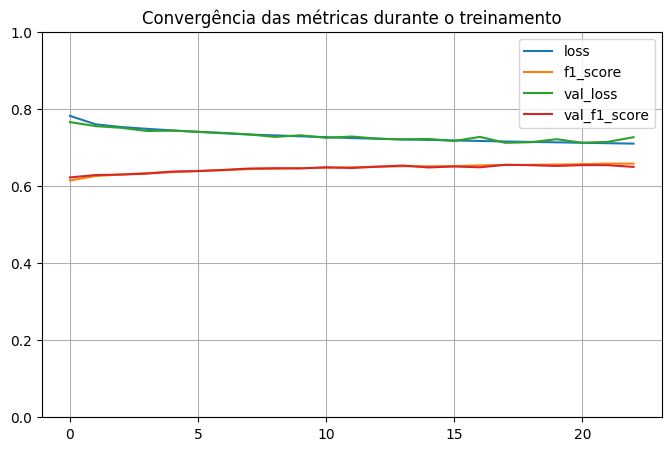

In [26]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title('Convergência das métricas durante o treinamento')
plt.show()

In [25]:
val_sample_preds = np.round(model2.predict(val_data_prepared))
print('F1_Score com conjunto de validação: ',f1_score(label_val_prepared, val_sample_preds, average='micro'))

815/815 [==============================] - 1s 1ms/step
F1_Score com conjunto de validação:  0.6506235728087124


Observa-se que a alteração na codificação dos dados categóricos e a redução dos atributos binários apenas reduziu a quantidade de entradas da rede, mas não trouxe nenhum outro benefício.

<h3>Conclusões</h3>

O uso do modelo Multilayer Perceptron não apresentou ganhos se comparado ao Random Forest utilizado na parte 1 do projeto. (Mesmo sendo um Random Forest simples e com quase nenhuma otimização dos hiperparâmetros.)

Ainda que a performance fosse semelhante não compensaria utilizar essa abordagem pelo maior tempo de processamento que ela demanda. Para que seja viável utilizar MLP neste problema, é necessário retornar à etapa de engenharia de atributos e avaliar a utilização dos índices de coordenada geográfica de nível 3. Além de testar outras codificações para as variáveis categóricas, como por exemplo, utilizando o TargetEncoder.